##### "Time Series Models in Foreign Exchange"
###### Appendix B: Python Code

###### Kris Walsh (kmw2221)
###### Columbia University Department of Economics
###### Master’s Thesis
###### Advisor: Professor Steven Ho 
###### December 4, 2020

Import Python Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import pandas_datareader as pdr
import itertools
import warnings
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

Download FX Time Series via Yahoo Finance API

In [2]:
fx_list = sorted(['eurusd=x', 'gbpusd=x', 'jpy=x', 'cad=x', 'mxn=x', 'zar=x'])
start = dt.datetime(2015,1,1)
end = dt.datetime(2020,6,30)

In [3]:
fx = pdr.DataReader(fx_list, 'yahoo', start, end)['Adj Close']

In [4]:
eur = fx['eurusd=x'].dropna()
gbp = fx['gbpusd=x'].dropna()
jpy = fx['jpy=x'].dropna()
cad = fx['cad=x'].dropna()
mxn = fx['mxn=x'].dropna()
zar = fx['zar=x'].dropna()

In [5]:
fx_basket = [eur, gbp, jpy, cad, mxn, zar]

Plot of the 6 time series

Text(0.5, 1.0, 'USDZAR')

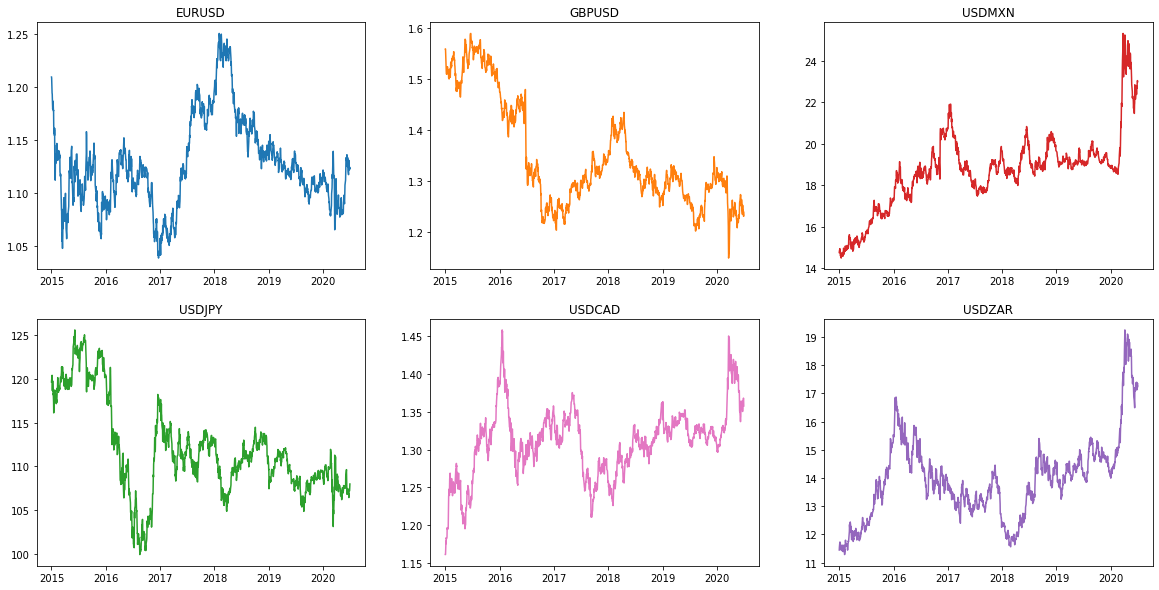

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(20,10))
axs[0, 0].plot(eur)
axs[0, 0].set_title('EURUSD')
axs[0, 1].plot(gbp, 'tab:orange')
axs[0, 1].set_title('GBPUSD')
axs[1, 0].plot(jpy, 'tab:green')
axs[1, 0].set_title('USDJPY')
axs[1, 1].plot(cad, 'tab:pink')
axs[1, 1].set_title('USDCAD')
axs[0, 2].plot(mxn, 'tab:red')
axs[0, 2].set_title('USDMXN')
axs[1, 2].plot(zar, 'tab:purple')
axs[1, 2].set_title('USDZAR')

ADF Test for Stationarity

In [7]:
def adf_test(currency): 
    adf_test = adfuller(currency)
    print('stat=%.3f, p=%.3f' % adf_test[0:2])
    if adf_test[1] > 0.05:
         print('Probably not Stationary')
    else:
         print('Probably Stationary')

In [8]:
for i in fx_basket:
    adf_test(i)

stat=-3.023, p=0.033
Probably Stationary
stat=-1.783, p=0.389
Probably not Stationary
stat=-2.328, p=0.163
Probably not Stationary
stat=-3.622, p=0.005
Probably Stationary
stat=-1.896, p=0.334
Probably not Stationary
stat=-1.610, p=0.478
Probably not Stationary


Split into Training and Test for ARIMA and Random Walk

In [9]:
eur_train = eur[:1144]
eur_test = eur[1145:]
gbp_train = gbp[:1144]
gbp_test = gbp[1145:]
jpy_train = jpy[:1144]
jpy_test = jpy[1145:]
cad_train = cad[:1144]
cad_test = cad[1145:]
mxn_train = mxn[:1144]
mxn_test = mxn[1145:]
zar_train = zar[:1144]
zar_test = zar[1145:]

Grid Search for ARIMA Parameters

In [10]:
warnings.filterwarnings('ignore')

In [11]:
def grid_search(currency):
    p = range(0, 4)
    d = range(1, 3)
    q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    aics = []
    params = []
    for param in pdq:
        model = ARIMA(currency, order=param)
        model_fit = model.fit()
        aic = model_fit.aic
        aics.append(aic)
        params.append(param)
    combo = list(zip(aics, params))
    combo.sort()
    combo_array = np.array(combo)
    print(combo_array)

In [12]:
fx_train_basket = [eur_train, gbp_train, jpy_train, cad_train, mxn_train, zar_train]

(Note: Grid Search may run for a few minutes)

In [13]:
for i in fx_train_basket:
    grid_search(i)

[[-8377.07926460606 (0, 1, 0)]
 [-8376.643272807625 (0, 1, 1)]
 [-8376.584601701035 (1, 1, 0)]
 [-8375.232795621481 (1, 1, 1)]
 [-8375.035461392245 (2, 1, 0)]
 [-8375.017673909657 (0, 1, 2)]
 [-8374.509415157665 (1, 1, 2)]
 [-8374.078956324534 (3, 1, 1)]
 [-8373.827880211886 (2, 1, 1)]
 [-8373.527394480545 (2, 1, 2)]
 [-8373.159511951706 (3, 1, 0)]
 [-8373.021895368869 (3, 1, 2)]
 [-8359.990406415993 (0, 2, 1)]
 [-8359.060025146677 (0, 2, 2)]
 [-8358.877446371665 (2, 2, 2)]
 [-8357.91392173284 (1, 2, 2)]
 [-8355.29734495656 (2, 2, 1)]
 [-8355.000927790197 (3, 2, 1)]
 [-8350.247861641381 (3, 2, 2)]
 [-8330.085198174134 (1, 2, 1)]
 [-8096.456140547243 (3, 2, 0)]
 [-8030.565245196905 (2, 2, 0)]
 [-7877.023336059554 (1, 2, 0)]
 [-7536.585038700723 (0, 2, 0)]]
[[-7678.279482555179 (3, 1, 1)]
 [-7677.820274978869 (1, 1, 2)]
 [-7677.603630289401 (2, 1, 2)]
 [-7677.314521416314 (2, 1, 1)]
 [-7677.128108194673 (3, 1, 0)]
 [-7676.901749403534 (0, 1, 0)]
 [-7676.210939763765 (3, 1, 2)]
 [-7675.46

Run Best-Fit ARIMA Models

In [13]:
model_arima_eur = ARIMA(eur_train, (0,1,1))
model_arima_gbp = ARIMA(gbp_train, (3,1,1))
model_arima_jpy = ARIMA(jpy_train, (2,1,2))
model_arima_cad = ARIMA(cad_train, (1,1,0))
model_arima_mxn = ARIMA(mxn_train, (2,1,2))
model_arima_zar = ARIMA(zar_train, (0,1,1))

In [14]:
model_arima_fit_eur = model_arima_eur.fit()
model_arima_fit_gbp = model_arima_gbp.fit()
model_arima_fit_jpy = model_arima_jpy.fit()
model_arima_fit_cad = model_arima_cad.fit()
model_arima_fit_mxn = model_arima_mxn.fit()
model_arima_fit_zar = model_arima_zar.fit()

In [15]:
arima_pred_eur = model_arima_fit_eur.forecast(len(eur_test), alpha=0.05)[0]
arima_pred_gbp = model_arima_fit_gbp.forecast(len(gbp_test), alpha=0.05)[0]
arima_pred_jpy = model_arima_fit_jpy.forecast(len(jpy_test), alpha=0.05)[0]
arima_pred_cad = model_arima_fit_cad.forecast(len(cad_test), alpha=0.05)[0]
arima_pred_mxn = model_arima_fit_mxn.forecast(len(mxn_test), alpha=0.05)[0]
arima_pred_zar = model_arima_fit_zar.forecast(len(zar_test), alpha=0.05)[0]

Report MSE of ARIMA vs Actual Currency Path

In [16]:
print(mean_squared_error(eur_test,arima_pred_eur))
print(mean_squared_error(gbp_test,arima_pred_gbp))
print(mean_squared_error(jpy_test,arima_pred_jpy))
print(mean_squared_error(cad_test,arima_pred_cad))
print(mean_squared_error(mxn_test,arima_pred_mxn))
print(mean_squared_error(zar_test,arima_pred_zar))

0.0001941545578032443
0.0026633357811622106
2.321791999598577
0.0017357273828908875
3.6527211112489475
2.2369263000545745


Zoom in on ARIMA forecasts, short (20 days) and long (286 days)

In [17]:
arima_pred_mxn_short = model_arima_fit_mxn.forecast(20, alpha=0.05)[0]
arima_pred_gbp_short = model_arima_fit_gbp.forecast(20, alpha=0.05)[0]

Text(0.5, 1.0, 'MXN Long Term ARIMA Forecast')

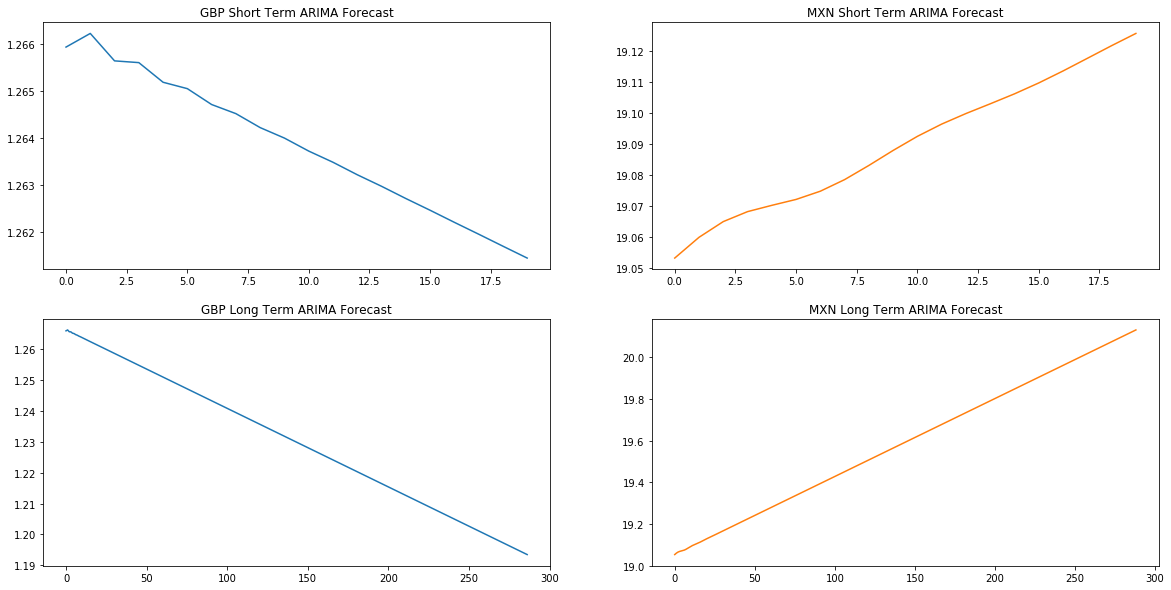

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(20,10))
axs[0, 0].plot(arima_pred_gbp_short)
axs[0, 0].set_title('GBP Short Term ARIMA Forecast')
axs[1, 0].plot(arima_pred_gbp)
axs[1, 0].set_title('GBP Long Term ARIMA Forecast')
axs[0, 1].plot(arima_pred_mxn_short, 'tab:orange')
axs[0, 1].set_title('MXN Short Term ARIMA Forecast')
axs[1, 1].plot(arima_pred_mxn, 'tab:orange')
axs[1, 1].set_title('MXN Long Term ARIMA Forecast')

Random Walk Results

In [19]:
model_arima_eur_rw = ARIMA(eur_train, (0,1,0))
model_arima_gbp_rw = ARIMA(gbp_train, (0,1,0))
model_arima_jpy_rw = ARIMA(jpy_train, (0,1,0))
model_arima_cad_rw = ARIMA(cad_train, (0,1,0))
model_arima_mxn_rw = ARIMA(mxn_train, (0,1,0))
model_arima_zar_rw = ARIMA(zar_train, (0,1,0))

In [20]:
model_arima_fit_eur_rw = model_arima_eur_rw.fit()
model_arima_fit_gbp_rw = model_arima_gbp_rw.fit()
model_arima_fit_jpy_rw = model_arima_jpy_rw.fit()
model_arima_fit_cad_rw = model_arima_cad_rw.fit()
model_arima_fit_mxn_rw = model_arima_mxn_rw.fit()
model_arima_fit_zar_rw = model_arima_zar_rw.fit()

In [21]:
arima_pred_eur_rw = model_arima_fit_eur_rw.forecast(len(eur_test), alpha=0.05)[0]
arima_pred_gbp_rw = model_arima_fit_gbp_rw.forecast(len(gbp_test), alpha=0.05)[0]
arima_pred_jpy_rw = model_arima_fit_jpy_rw.forecast(len(jpy_test), alpha=0.05)[0]
arima_pred_cad_rw = model_arima_fit_cad_rw.forecast(len(cad_test), alpha=0.05)[0]
arima_pred_mxn_rw = model_arima_fit_mxn_rw.forecast(len(mxn_test), alpha=0.05)[0]
arima_pred_zar_rw = model_arima_fit_zar_rw.forecast(len(zar_test), alpha=0.05)[0]

In [22]:
print(mean_squared_error(eur_test,arima_pred_eur_rw))
print(mean_squared_error(gbp_test,arima_pred_gbp_rw))
print(mean_squared_error(jpy_test,arima_pred_jpy_rw))
print(mean_squared_error(cad_test,arima_pred_cad_rw))
print(mean_squared_error(mxn_test,arima_pred_mxn_rw))
print(mean_squared_error(zar_test,arima_pred_zar_rw))

0.00019388120775006782
0.002674872365574409
2.3232498934950008
0.001734354839061851
3.6541375740629225
2.251010706606456


Zoom in on Random Walk forecasts, short (20 days) and long (286 days)

In [23]:
arima_pred_mxn_short_rw = model_arima_fit_mxn_rw.forecast(20, alpha=0.05)[0]
arima_pred_gbp_short_rw = model_arima_fit_gbp_rw.forecast(20, alpha=0.05)[0]

Text(0.5, 1.0, 'MXN Long Term Random Walk Forecast')

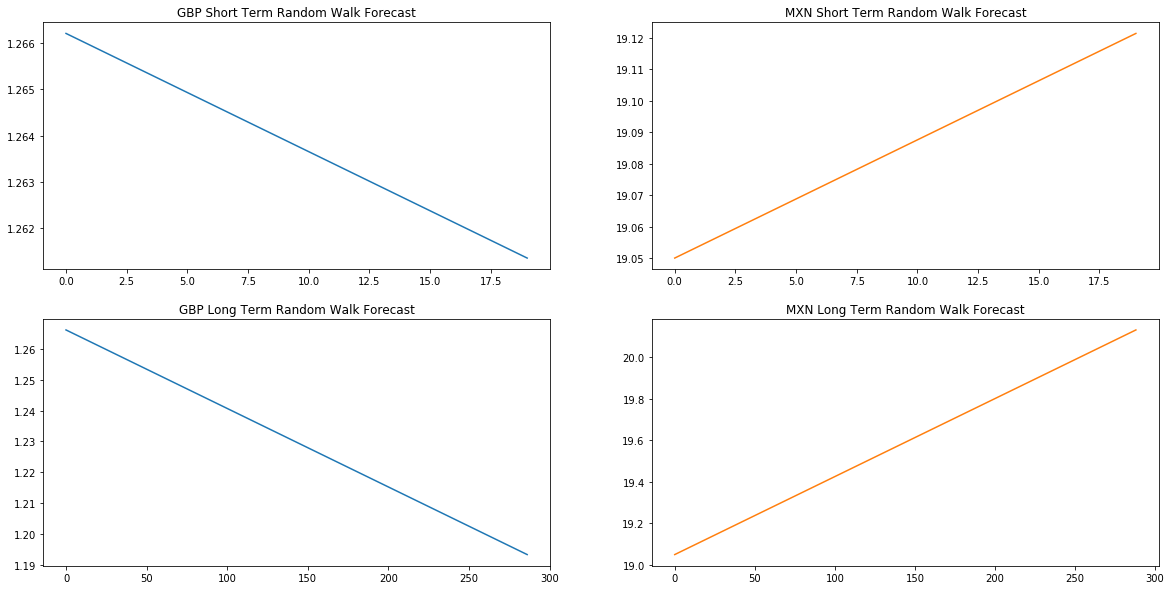

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(20,10))
axs[0, 0].plot(arima_pred_gbp_short_rw)
axs[0, 0].set_title('GBP Short Term Random Walk Forecast')
axs[1, 0].plot(arima_pred_gbp_rw)
axs[1, 0].set_title('GBP Long Term Random Walk Forecast')
axs[0, 1].plot(arima_pred_mxn_short_rw, 'tab:orange')
axs[0, 1].set_title('MXN Short Term Random Walk Forecast')
axs[1, 1].plot(arima_pred_mxn_rw, 'tab:orange')
axs[1, 1].set_title('MXN Long Term Random Walk Forecast')

Neural Network (Long Short-Term Memory)

In [311]:
df = gbp

In [312]:
scaler = MinMaxScaler()

In [313]:
df = np.array(df).reshape(-1,1)

In [314]:
df = scaler.fit_transform(df)

In [315]:
#Training and test sets
train = df[:1145]
test = df[1145:]

In [316]:
def get_data(data, look_back):
  data_x, data_y = [],[]
  for i in range(len(data)-look_back-1):
    data_x.append(data[i:(i+look_back),0])
    data_y.append(data[i+look_back,0])
  return np.array(data_x) , np.array(data_y)

look_back = 1

x_train , y_train = get_data(train, look_back)

In [317]:
x_test , y_test = get_data(test,look_back)

In [318]:
#Processing train and test sets for LSTM model
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [319]:
print(x_train.shape)
print(x_test.shape)

(1143, 1, 1)
(285, 1, 1)


In [320]:
#Defining the LSTM model
n_features=x_train.shape[1]
model=Sequential()
model.add(LSTM(10,activation='relu',input_shape=(1,1)))
model.add(Dense(n_features))

In [321]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [322]:
#Compiling
model.compile(optimizer='adam', loss = 'mse')

In [323]:
#Training
model.fit(x_train,y_train, epochs = 5, batch_size=1)

Epoch 1/5
1143/1143 [==============================] - 1s 829us/step - loss: 0.0478
Epoch 2/5
1143/1143 [==============================] - 1s 799us/step - loss: 0.0032
Epoch 3/5
1143/1143 [==============================] - 1s 790us/step - loss: 6.5629e-04
Epoch 4/5
1143/1143 [==============================] - 1s 797us/step - loss: 6.2170e-04
Epoch 5/5
1143/1143 [==============================] - 1s 798us/step - loss: 6.0541e-04 0s - loss: 6.0431e-0


In [324]:
#Prediction using the trained model
scaler.scale_
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)

In [325]:
#Processing test shape
y_test = np.array(y_test).reshape(-1,1)
y_test = scaler.inverse_transform(y_test)

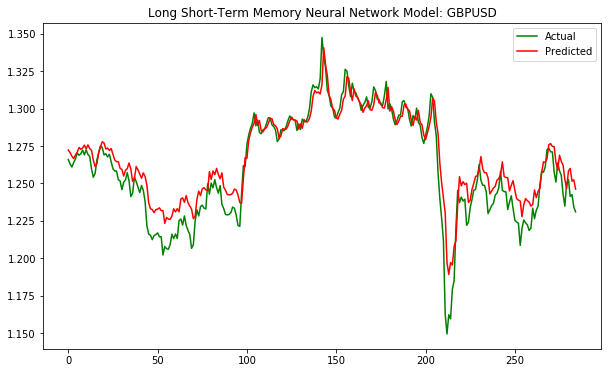

In [326]:
#Visualizing the results
plt.figure(figsize=(10,6))
plt.title('Long Short-Term Memory Neural Network Model: GBPUSD')
plt.plot(y_test , label = 'Actual', color = 'g')
plt.plot(y_pred , label = 'Predicted', color = 'r')
plt.legend()


In [327]:
mean_squared_error(y_test, y_pred)

0.00015780838623259154

In [328]:
y_diff = y_pred - y_test

In [329]:
y_diff_df = pd.DataFrame(data=y_diff)

In [330]:
y_pred_df = pd.DataFrame(data=y_pred)

In [331]:
y_actual_df = pd.DataFrame(data=y_test)

In [332]:
full_table = pd.concat([y_actual_df, y_pred_df, y_diff_df], axis=1)

In [333]:
table_columns = ['Actual', 'Predicted', 'Gap']

In [334]:
full_table.columns = table_columns

In [335]:
full_table['Position'] = np.where(full_table['Gap'] >= 0, 1, -1)

In [336]:
full_table['Prior Actual'] = full_table['Actual'].shift(1)

In [337]:
full_table['Return'] = (full_table['Actual'] - full_table['Prior Actual'])*(full_table['Position'])

In [338]:
full_table['Return_Percent'] = full_table['Return']/full_table['Actual']

In [339]:
full_table['Cum Ret'] = ((full_table['Return_Percent'] + 1).cumprod() - 1)

Text(0.5, 1.0, 'Cumulative Return of Neural Network Strategy: GBPUSD')

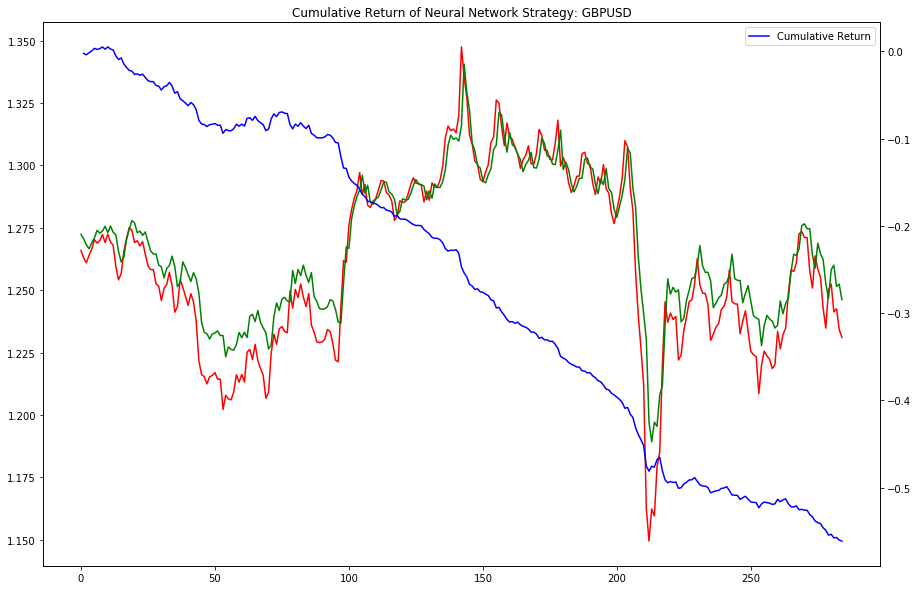

In [341]:
fig, ax_left = plt.subplots(figsize = (15,10))
ax_right = ax_left.twinx()
ax_left.plot(full_table['Actual'], color='r', label = 'Actual')
ax_left.plot(full_table['Predicted'], color = 'g', label = 'Predicted')
ax_right.plot(full_table['Cum Ret'], color='b', label = 'Cumulative Return')
plt.legend()
plt.title('Cumulative Return of Neural Network Strategy: GBPUSD')